In [219]:
# Data Overall
import numpy as np
import pandas as pd

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

%matplotlib inline
sns.set()

# EDA and other initial exploration

<b>Note</b>: most of the steps from this point onwards are taken with the intention of ultimately predicting median GPA

In [59]:
# Data
raw_data = pd.read_csv("Dartmouth - Courses.csv", index_col = 0)

In [62]:
raw_data.head(10)

,Year,Term Number,Department,Course Number,Number of Sections,Enrollments,Median GPA Points,Average Section Size
0,NaN,NaN,AAAS,31.10,1.0,14.0,4.000000,14.0
1,2021.0,3.0,AAAS,31.90,1.0,17.0,4.000000,17.0
2,2021.0,3.0,AAAS,60.01,1.0,19.0,3.666667,NaN
3,2021.0,3.0,AAAS,62.75,1.0,29.0,4.000000,29.0
4,2021.0,3.0,AAAS,65.65,1.0,16.0,3.333333,16.0
5,2021.0,3.0,AAAS,88.19,1.0,19.0,4.000000,19.0
6,2021.0,3.0,ANTH,3.00,1.0,58.0,NaN,58.0
7,2021.0,3.0,ANTH,18.00,1.0,16.0,4.000000,16.0
8,2021.0,3.0,NaN,12.19,1.0,24.0,4.000000,24.0
9,2021.0,3.0,ARTH,17.06,1.0,21.0,3.666667,21.0


In [65]:
# Number of unique values per column, helpful in determining if some could be re-encoded as categorical values
[print(f"unique: {raw_data[col].nunique()} - {col}") for col in raw_data]

unique: 2 - Year
unique: 4 - Term Number
unique: 58 - Department
unique: 557 - Course Number
unique: 10 - Number of Sections
unique: 136 - Enrollments
unique: 43 - Median GPA Points
unique: 125 - Average Section Size


[None, None, None, None, None, None, None, None]

## Studying relationship between department and metrics by dept.

In [32]:
# Mean metrics by dept.
dept_metrics = raw_data.groupby('Department')[['Enrollments','Median GPA Points','Average Section Size']].mean()

In [41]:
# 10 depts. w/ lowest mean GPA
dept_metrics.sort_values(by="Median GPA Points").head(10)

,Enrollments,Median GPA Points,Average Section Size
Department,,,
CHEM,59.909091,3.397436,48.950000
EDUC,29.166667,3.444444,27.142857
BIOL,28.611111,3.480392,25.671053
ECON,84.230769,3.509615,40.652778
GOVT,24.273973,3.559950,22.730263
PBPL,29.083333,3.621212,32.666667
INTS,25.500000,3.666667,26.400000
ASTR,54.500000,3.666667,40.166667
TUCK,204.000000,3.666667,102.000000


In [42]:
# 10 highest-enrollment depts.
dept_metrics.sort_values(by="Enrollments", ascending = False).head(10)

,Enrollments,Median GPA Points,Average Section Size
Department,,,
TUCK,204.000000,3.666667,102.000000
MATH,110.216216,3.754630,40.576923
SPAN,103.636364,3.867647,25.914286
ECON,84.230769,3.509615,40.652778
HUM,76.000000,3.866641,25.666667
WRIT,74.384615,3.864557,15.991037
CHEM,59.909091,3.397436,48.950000
ASTR,54.500000,3.666667,40.166667
COSC,53.520833,3.773935,41.290780


# Data Visualization

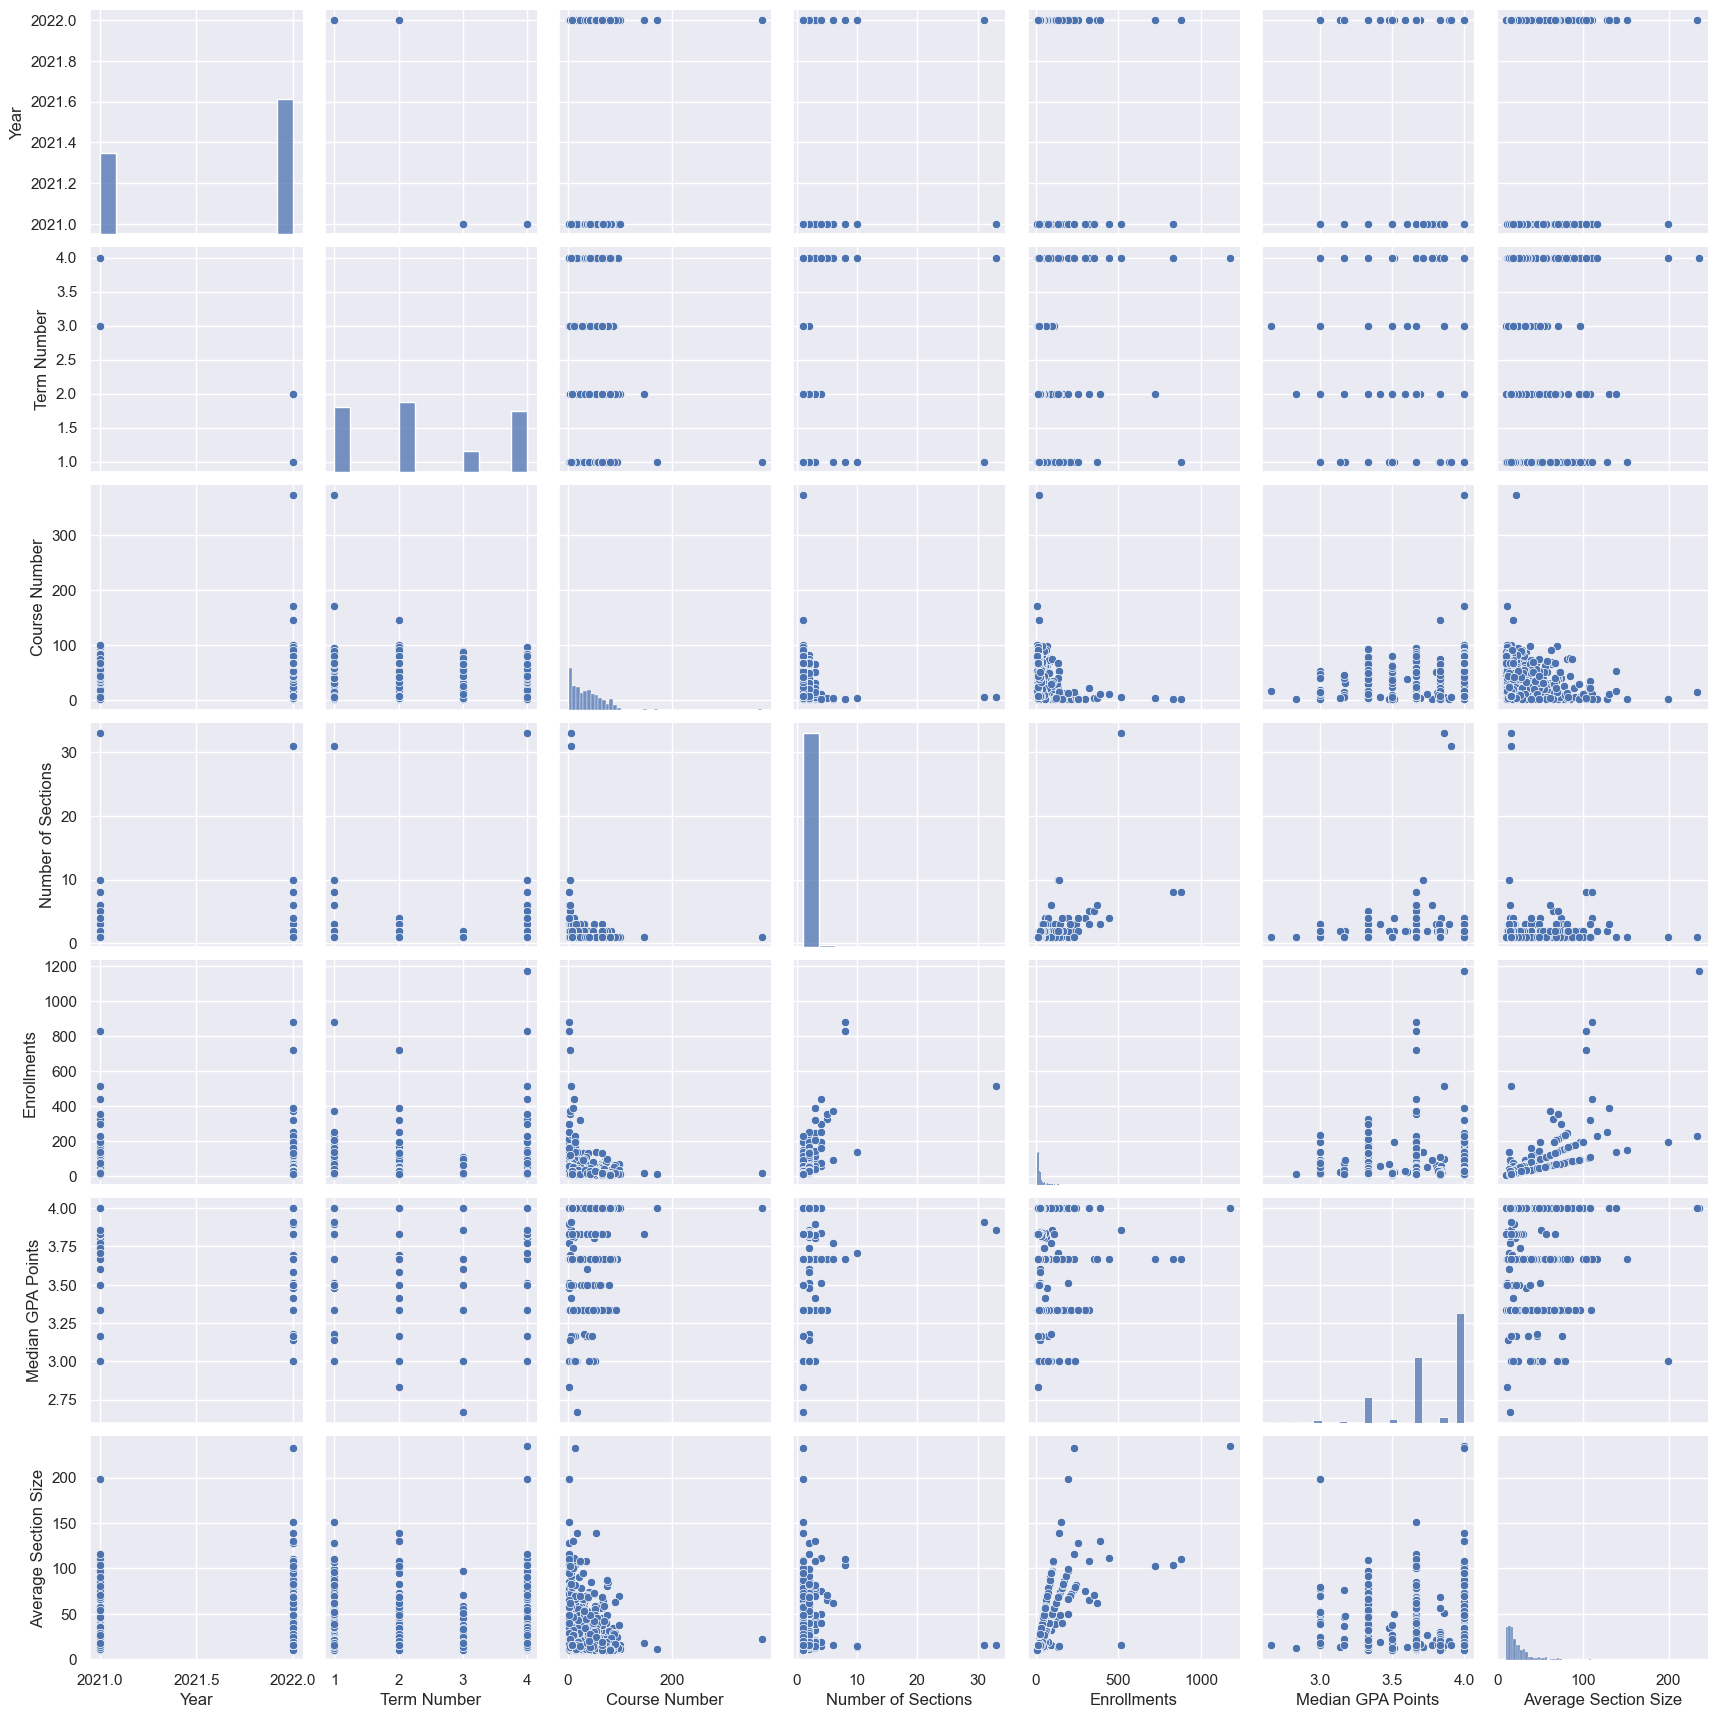

In [158]:
# From the following output, we can quickly see that 
# 1) Course number and section size seem inversely correlated
# 2) Enrollments and section size are positively correlated
# Generally, don't seem to be any columns that are super-well suited for predicting median GPA or other interesting columns

sns.pairplot(raw_data)

<Axes: xlabel='Median GPA Points', ylabel='Count'>

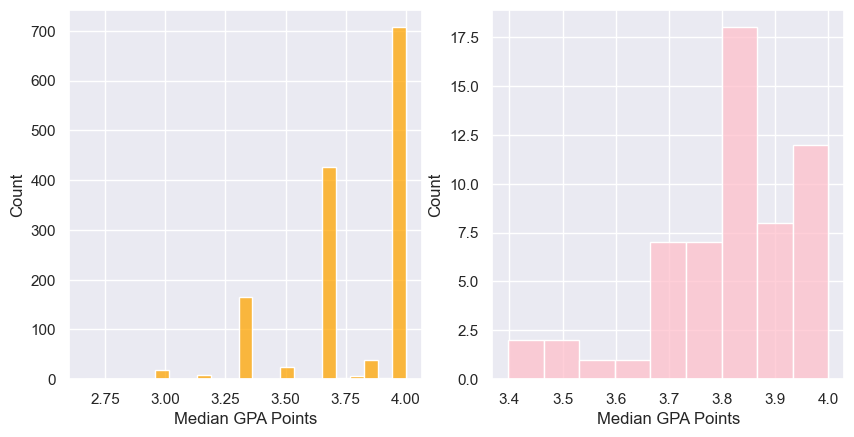

In [188]:
# Distribution of GPA across individual courses and departments
# More skewed distr. across individual courses
f, axes = plt.subplots(nrows=1, ncols=2)
f.set_figwidth(10)
sns.histplot(data=raw_data,x="Median GPA Points",color='orange',ax=axes[0])
sns.histplot(data=dept_metrics,x="Median GPA Points",color='pink',ax=axes[1])

## Studying individual departments

In [177]:
# Department data
depts = ["COSC","ENGS","SPAN"]
c = ["blue","green","orange"]
data_by_depts = [raw_data[raw_data['Department']=="COSC"],
                 raw_data[raw_data['Department']=="ENGS"],
                 raw_data[raw_data['Department']=="SPAN"]]

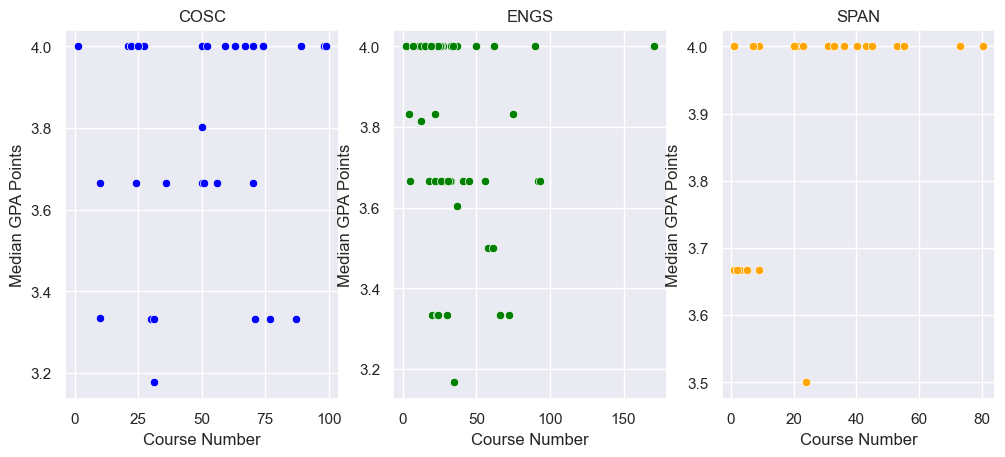

In [185]:
## Course number vs. median GPA across these departments
# Nothing clear from the following; only that SPAN generally tends to be around ~4.0 as the course number increases
# Also, can see that ENGS course numbers here tend to be lower than the other two

f, axes = plt.subplots(nrows=1, ncols=3)
f.set_figwidth(12)

for i in range(3):
    sns.scatterplot(data=data_by_depts[i],x="Course Number",y="Median GPA Points",ax=axes[i],color=c[i]).set(title=depts[i])

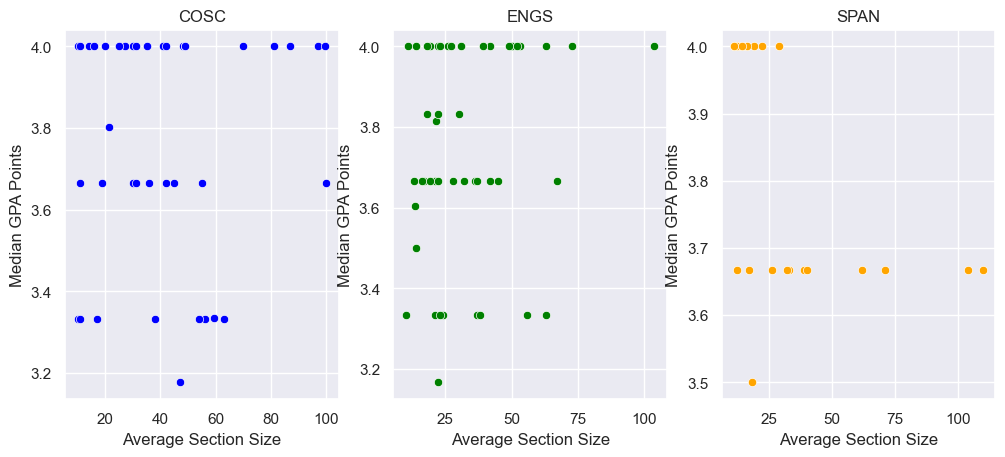

In [184]:
## Average section size vs. median GPA across these departments
# Again, nothing super clear, only that both COSC and ENGS seem to kind of follow a pattern where most GPAs hover around 4.0, 3.67, or 3.3

f, axes = plt.subplots(nrows=1, ncols=3)
f.set_figwidth(12)

for i in range(3):
    sns.scatterplot(data=data_by_depts[i],x="Average Section Size",y="Median GPA Points",ax=axes[i],color=c[i]).set(title=depts[i])

## Data by department means

<Axes: xlabel='Average Section Size', ylabel='Enrollments'>

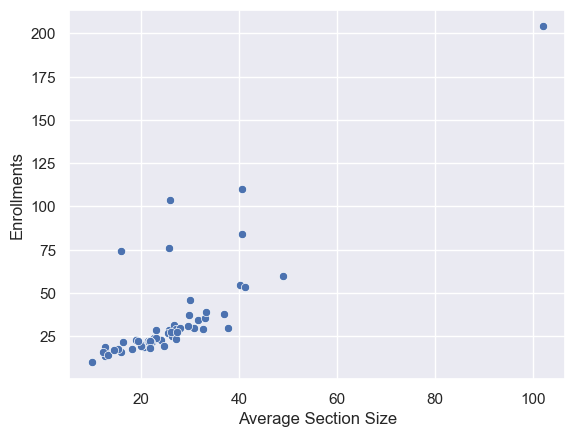

In [135]:
# Relatively logical linear correlation between the number of spots for a course and the number of students that enroll
sns.scatterplot(data=dept_metrics,x="Average Section Size",y="Enrollments")

<Axes: xlabel='Average Section Size', ylabel='Median GPA Points'>

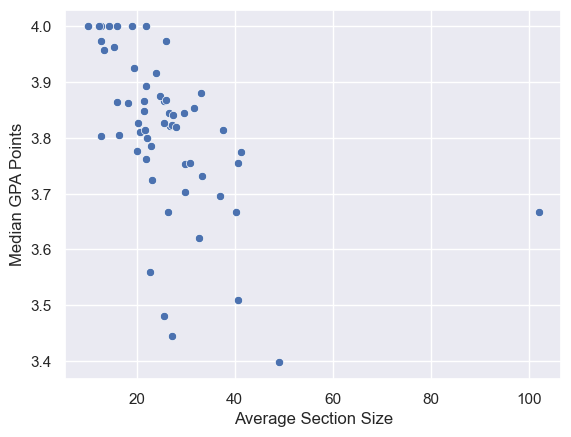

In [187]:
# Across departments, average section size seems inversely correlated with median GPA
sns.scatterplot(data=dept_metrics,x="Average Section Size",y="Median GPA Points")

# Preprocessing & other analyses

## Initial imputation 

In [198]:
# Null values
print(f"{sum(raw_data.isna().sum())} null values")

1248 null values


In [129]:
# Several null values, and ignoring them could be a mistake since represent relatively significant portion of the data
# For now, can impute the missing values using a relatively simple (albeit naive) imputer based on KNN

In [130]:
# Fit imputer instance to the data
imputer = KNNImputer()
numerical_course_data = raw_data.drop(['Department'],axis=1)
imputer.fit(numerical_course_data)

# Transforming data
imputed_matrix = imputer.transform(numerical_course_data)
data_filled = pd.concat([raw_data[['Department']],pd.DataFrame(imputed_matrix)], axis=1)
data_filled.columns = ['Department'] + list(numerical_course_data.columns)

# Rounding (year contains discrete values in {2021, 2022}; same for term number, number of sections, enrollments)
for col in ["Year","Term Number","Number of Sections","Enrollments"]:
    data_filled[col] = data_filled[col].round()

In [131]:
data_filled.head(10)

,Department,Year,Term Number,Course Number,Number of Sections,Enrollments,Median GPA Points,Average Section Size
0,AAAS,2022.0,2.0,31.10,1.0,14.0,4.000000,14.0
1,AAAS,2021.0,3.0,31.90,1.0,17.0,4.000000,17.0
2,AAAS,2021.0,3.0,60.01,1.0,19.0,3.666667,28.8
3,AAAS,2021.0,3.0,62.75,1.0,29.0,4.000000,29.0
4,AAAS,2021.0,3.0,65.65,1.0,16.0,3.333333,16.0
5,AAAS,2021.0,3.0,88.19,1.0,19.0,4.000000,19.0
6,ANTH,2021.0,3.0,3.00,1.0,58.0,3.933333,58.0
7,ANTH,2021.0,3.0,18.00,1.0,16.0,4.000000,16.0
8,NaN,2021.0,3.0,12.19,1.0,24.0,4.000000,24.0
9,ARTH,2021.0,3.0,17.06,1.0,21.0,3.666667,21.0


## Brief Correlation Analysis

At this point, <b>Average Section Size</b> and <b>Enrollments</b> seem to be among the most highly correlated with median GPA, substantiated by the following:

In [193]:
# Pearson
raw_data.corr(numeric_only=True, method='pearson')['Median GPA Points']

Year                    0.075341
Term Number            -0.041822
Course Number           0.102607
Number of Sections     -0.047424
Enrollments            -0.138981
Median GPA Points       1.000000
Average Section Size   -0.192075
Name: Median GPA Points, dtype: float64

In [194]:
# Spearman
raw_data.corr(numeric_only=True, method='spearman')['Median GPA Points']

Year                    0.081124
Term Number            -0.031838
Course Number           0.085124
Number of Sections     -0.177680
Enrollments            -0.260181
Median GPA Points       1.000000
Average Section Size   -0.240319
Name: Median GPA Points, dtype: float64

In [197]:
# Note that these values remain almost exactly the same after imputation with 'data_filled'

# Machine Learning

Since many of the attributes of the data seem to exhibit linear relationships with median GPA, we can start by using linear regression to predict median GPA. 
* Note that while departments did seem to have characteristic metrics for themselves, the fact that there are ~58 of them could mean that encoding them as dummy variables or including them as categoricals in some other way could just complicate our problem.
* Because of that (and the fact that this model can't handle such inputs), disregard the <b>Department</b> feature

## With all numerical params

In [216]:
feature_df = data_filled.drop(["Median GPA Points","Department"],axis=1)
target_df = data_filled['Median GPA Points']

# Splitting into training and testing sets
X = feature_df.values
y = target_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [217]:
# Fitting model
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [228]:
# Comparing accuracy with X_test,y_test
predictions = lm.predict(X_test)

# Metrics
print(f"Coefficient: {lm.coef_}")
print(f"R^2: {r2_score(y_test,predictions)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test,predictions)}")
print(f"Mean Squared Error: {mean_squared_error(y_test,predictions)}")

Coefficient: [ 0.03190877  0.00781665  0.00066003 -0.02927733  0.00020708 -0.00234038]
R^2: 0.0011323853365505787
Mean Absolute Error: 0.20509542011114476
Mean Squared Error: 0.05836950201887809


## With specific features (section size & enrollments)

In [248]:
spec_feature_df = data_filled[['Average Section Size','Enrollments']]
spec_target_df = data_filled['Median GPA Points']

# Splitting into training and testing sets
X_spec = spec_feature_df.values
y_spec = spec_target_df.values

X_train_spec, X_test_spec, y_train_spec, y_test_spec = train_test_split(X_spec, y_spec, test_size=0.33, random_state=42)

In [249]:
# Fitting model
lm_spec = LinearRegression()
lm_spec.fit(X_train_spec,y_train_spec)

LinearRegression()

In [250]:
# Comparing accuracy with X_test,y_test
predictions_spec = lm_spec.predict(X_test_spec)

# Metrics
print(f"Coefficient: {lm_spec.coef_}")
print(f"R^2: {r2_score(y_test_spec,predictions_spec)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_spec,predictions_spec)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_spec,predictions_spec)}")

Coefficient: [-0.00219618 -0.00010162]
R^2: 0.045423063295774835
Mean Absolute Error: 0.202349943772338
Mean Squared Error: 0.055781346412862705


## With only section size

In [240]:
size_feature_df = data_filled[['Average Section Size']]
size_target_df = data_filled['Median GPA Points']

# Splitting into training and testing sets
X_size = size_feature_df.values
y_size= size_target_df.values

X_train_size, X_test_size, y_train_size, y_test_size = train_test_split(X_size, y_size, test_size=0.33, random_state=42)

In [241]:
# Fitting model
lm_size = LinearRegression()
lm_size.fit(X_train_size,y_train_size)

LinearRegression()

In [289]:
# Comparing accuracy with X_test,y_test
predictions_size = lm_size.predict(X_test_size)

# Metrics
print(f"Coefficient: {lm_size.coef_}")
print(f"R^2: {r2_score(y_test_size,predictions_size)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_size,predictions_size)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_spec,predictions_size)}")

Coefficient: [-0.00237182]
R^2: 0.046961194848054055
Mean Absolute Error: 0.20223796261112695
Mean Squared Error: 0.05569146465933693


## Conclusion with feature selection across all data

The regression models seemed to perform the best with <b>Average Section Size</b> as the predictor for <b>Median GPA Points</b>, with the above metrics. The model described the relationship between these two attributes with the following regression line for test values:

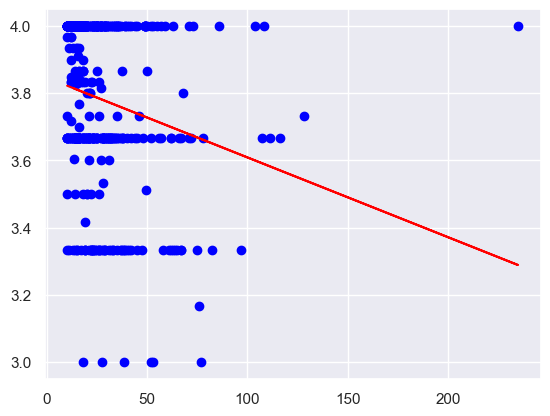

In [292]:
plt.scatter(X_test_size,y_test_size,color="blue")
plt.plot(X_test_size,predictions_size,color="red")

## Applying model to specific departments

We can also try modeling the median GPA for a specific department with a decent sample size.

In [299]:
# Sorting by the number of courses by department
dept_sizes = pd.DataFrame([[dept,len(raw_data[raw_data["Department"]==dept])] for dept in raw_data["Department"].unique()],columns=["dept","size"])
dept_sizes.sort_values(by="size",ascending=False).head(5)

,dept,size
24,GOVT,86
25,HIST,72
17,ENGS,65
14,ECON,56
11,COSC,53


In [300]:
# For a few of these, we can try to predict median GPA using section size as before

### GOVT

In [285]:
# Extracting GOVT data
govt_data = data_filled[data_filled['Department'] == "GOVT"]
govt_feature_df = govt_data[['Average Section Size']]
govt_target_df = govt_data['Median GPA Points']

# Splitting into training and testing sets
X_govt = govt_feature_df.values
y_govt= govt_target_df.values

X_train_govt, X_test_govt, y_train_govt, y_test_govt = train_test_split(X_govt, y_govt, test_size=0.33, random_state=42)

In [288]:
# Fitting model
lm_govt = LinearRegression()
lm_govt.fit(X_train_govt,y_train_govt)

LinearRegression()

In [290]:
# Comparing accuracy with X_test,y_test
predictions_govt = lm_govt.predict(X_test_govt)

# Metrics
print(f"Coefficient: {lm_govt.coef_}")
print(f"R^2: {r2_score(y_test_govt,predictions_govt)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_govt,predictions_govt)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_govt,predictions_govt)}")

Coefficient: [-0.00882946]
R^2: 0.001803455277154753
Mean Absolute Error: 0.20227815611482747
Mean Squared Error: 0.05346452817710959


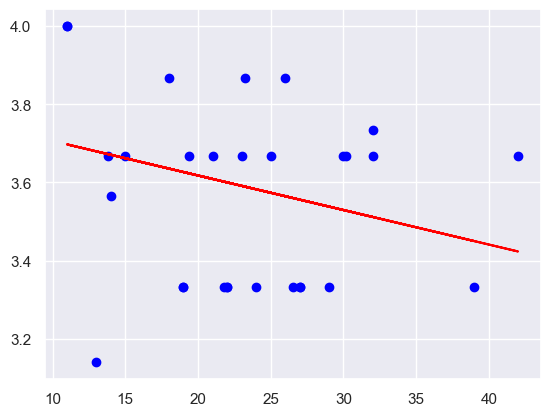

In [293]:
# Plotting true vs. pred
plt.scatter(X_test_govt,y_test_govt,color="blue")
plt.plot(X_test_govt,predictions_govt,color="red")

### COSC

In [301]:
# Extracting COSC data
cosc_data = data_filled[data_filled['Department'] == "COSC"]
cosc_feature_df = cosc_data[['Average Section Size']]
cosc_target_df = cosc_data['Median GPA Points']

# Splitting into training and testing sets
X_cosc = cosc_feature_df.values
y_cosc = cosc_target_df.values

X_train_cosc, X_test_cosc, y_train_cosc, y_test_cosc = train_test_split(X_cosc, y_cosc, test_size=0.33, random_state=42)

In [302]:
# Fitting model
lm_cosc = LinearRegression()
lm_cosc.fit(X_train_cosc,y_train_cosc)

LinearRegression()

In [304]:
# Comparing accuracy with X_test,y_test
predictions_cosc = lm_cosc.predict(X_test_cosc)

# Metrics
print(f"Coefficient: {lm_cosc.coef_}")
print(f"R^2: {r2_score(y_test_cosc,predictions_cosc)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_cosc,predictions_cosc)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_cosc,predictions_cosc)}")

Coefficient: [0.00142241]
R^2: -0.042607536274967606
Mean Absolute Error: 0.2231176505050425
Mean Squared Error: 0.06288539556928714


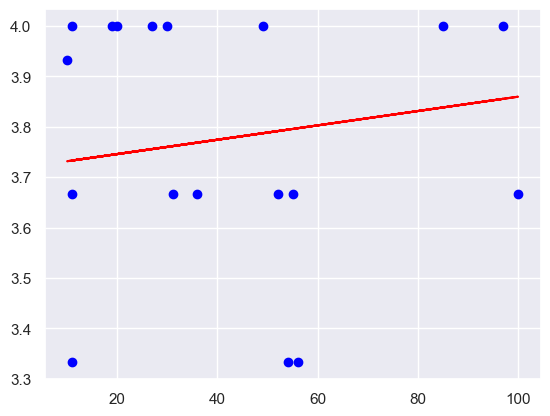

In [305]:
# Plotting true vs. pred
plt.scatter(X_test_cosc,y_test_cosc,color="blue")
plt.plot(X_test_cosc,predictions_cosc,color="red")

In either case, the model doesn't seem to perform particularly well and instead performed far better on the overall dataset, likely because of sample size or related issues.